In [5]:
import sys
import time
import copy
import pickle
from pathlib import Path
from natsort import natsorted
from glob import glob
from tqdm import tqdm
from foolbox.models import PyTorchModel
from art.estimators.classification import PyTorchClassifier
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import cupy as cp
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import gc
import resource
from art.estimators.classification import PyTorchClassifier
from sklearn import metrics
from scipy import stats
from skimage.metrics import structural_similarity
from image_similarity_measures import quality_metrics
import albumentations as albument
from sklearn.metrics import classification_report

sys.path.insert(0, '../')

from utils import seed
from data import cifar

# Data loading

In [6]:
# %matplotlib widget
%matplotlib inline
seed.init_seed()

# attack = "PGD"
attack = "FGSM"

dataset = "imagenet"
# dataset = "cifar10"
# dataset = "cifar100"

data_dir = "project_data/"
save_dir = "project_data/experiment1/results_parts/"

if dataset == "imagenet" and attack == "FGSM":
    run = 2
elif dataset == "cifar10" and attack == "FGSM":
    run = 0
elif dataset == "cifar100" and attack == "FGSM":
    run = 1
    # run = 1
elif dataset == "imagenet" and attack == "PGD":
    run = 9
elif dataset == "cifar10" and attack == "PGD":
    run = 6
elif dataset == "cifar100" and attack == "PGD":
    run = 8
else:
    exit()

dataset_runs = [
    # {"path": f"../project_data/experiment1/results_parts/run{str(run)}/{dataset}/", "save_path": f"../project_data/experiment1/result_plots/run{str(run)}/"}
    {"path": f"../project_data/experiment1/final_results/run{str(run)}/{dataset}/", "save_path": f"../project_data/experiment1/result_plots/run{str(run)}/"}
]
indexes = {"100": "(0, 100)", "200":"(0, 200)", "300":"(0, 300)", "500":"(0, 500)", "600":"(0, 600)", "700":"(0, 700)", "1000":"(0, 1000)", "1200":"(0, 1200)", "1500":"(0, 1500)", "2000":"(0, 2000)", "3000":"(0, 3000)", "5000":"(0, 5000)", "7000":"(0, 7000)", "10000": "(0, 10000)"}

run = dataset_runs[0]

path = run['path']
save_plot_path = run['save_path']

if not os.path.exists(save_plot_path):
    os.makedirs(save_plot_path)

attack_list = {}

att_names = {
    "LinfProjectedGradientDescentAttack": "PGDLinf",
    "L2ProjectedGradientDescentAttack": "PGDL2",
    "L2FastGradientAttack": "FGSML2",
    "LinfFastGradientAttack": "FGSMLinf"
}
named_labels = {}
file_data = {}
for f_name in natsorted(glob(f"{path}**/*.pickle")):
    if len(Path(f_name).stem.split("_")) > 1:
        continue

    version, key, norm = Path(f_name).stem.split(".")
    if int(key) > 2000:
        continue
    if norm == "inf":
        norm = str(np.inf)
    if version == "0":
        version = ""
    elif version == "1":
        version = "Straightened "

    net_name = version + Path(f_name).parent.name + norm
    named_labels[net_name] = version
    if net_name not in file_data:
        file_data[net_name] = {}
    
    with open(f_name, 'rb') as handle:
        # print(f_name)
        # key = Path(f_name).stem
        file_data[net_name][key], experiment_settings = pickle.load(handle)

        attack, _ = str(experiment_settings['attack']).split('(')
        if attack in att_names:
            attack = att_names[attack]

        attack_list[net_name] = attack
        # print(experiment_settings['attack'])
        # print(experiment_settings)
        # file_data[net_name][key]['name'] = f_name

if len(file_data) == 0:
    print("File data is empty")
    print(file_data)

dataset = dataset.capitalize() 

# Data processing

In [ ]:
with_clever = False

comp = "completeness"
all_file_data = {}
if with_clever:
    clever_scores_means = {}

for net_name, files in file_data.items():
    all_file_data[net_name] = {}
    if with_clever:
        clever_scores_means[net_name] = {}
    for k, data in files.items():
        if with_clever:
            clever_scores_means[net_name][k] = {}
        for d, values in data.items():
            if d not in all_file_data[net_name]:
                all_file_data[net_name][d] = {}
                
            if comp not in all_file_data[net_name]:
                all_file_data[net_name][comp] = {}

            # if k in completeness_data:
            #     all_file_data[net_name][comp][k] = completeness_data[k]

            all_file_data[net_name][d][k] = values
        if with_clever:
            if len(data['clever']) > 0 and type(data['clever']) == dict:
                for key, val in data['clever'].items():
                    clever_scores_means[net_name][k][key] = np.mean(val)

                clever_scores_means[net_name][k] = np.mean(val)

key_emp = ['completeness', 'lsa_values', 'amise', 'amise_f1', 'emperical_robustness', 'emperical_robustness_logits']
if with_clever:
    # keys = ['clever', 'equivalence_part', 'Centroid_part', 'bound_part', 'pairw_part', 'fol_L2', 'fol_Linf']
    keys = ['clever', 'equivalence_part', 'Centroid_part', 'fol_L2', 'fol_Linf']
else:
    # keys = ['equivalence_part', 'Centroid_part', 'bound_part', 'pairw_part', 'fol_L2', 'fol_Linf']
    keys = ['equivalence_part', 'Centroid_part', 'fol_L2', 'fol_Linf']
for net_name, files in all_file_data.items():
    for key in keys:
        files[f"{key}_"] = {}
        files[f"{key}_mean"] = {}
        for label, data in files[key].items():
            if key in ['fol_L2', 'fol_Linf']:
                # print(data)
                files[f"{key}_"][label] = {}
                for eps, d in data.items():
                    if len(d) == 0:
                        files[f"{key}_"][label][eps] = 0
                    else:
                        files[f"{key}_"][label][eps] = sum(d.values()) / len(d)
                data = files[f"{key}_"][label]

            if len(data) == 0:
                files[f"{key}_mean"][label] = 0
            else:
                files[f"{key}_mean"][label] = sum(data.values()) / len(data)

for net_name, files in all_file_data.items():
    for key in key_emp:
        _key = f"{key}_"
        __key = f"{key}__"
        files[_key] = {}
        files[__key] = {}
        files[f"{_key}mean"] = {}
        # label: data size, data: data
        for label, data in files[key].items():
            # print(data.keys())
            # k: Rob type,
            for rob_type, data_per_eps in data.items():
                if rob_type not in ['approx', 'diff', 'calc_diff', 'mean', 'all']:
                    continue

                if rob_type not in files[_key]:
                    files[_key][rob_type] = {}
                    files[f"{_key}mean"][rob_type] = {}

                if type(data_per_eps) == np.float64:
                    files[_key][rob_type][label] = data_per_eps
                    continue

                if rob_type not in files[__key]:
                    files[__key][rob_type] = {}

                if label not in files[_key][rob_type]:
                    files[_key][rob_type][label] = {}
                    files[f"{_key}mean"][rob_type][label] = {}

                if type(data_per_eps) == list:
                    for eps, data_point in enumerate(data_per_eps):
                        if eps not in files[__key][rob_type]:
                            files[__key][rob_type][eps] = {}

                            
                        files[_key][rob_type][label][eps] = data_point
                        files[__key][rob_type][eps][label] = data_point
                else:
                    for eps, data_point in data_per_eps.items():
                        if eps not in files[__key][rob_type]:
                            files[__key][rob_type][eps] = {}

                        files[_key][rob_type][label][eps] = data_point
                        files[__key][rob_type][eps][label] = data_point

                data = files[_key][rob_type][label]

                if len(data) == 0:
                    files[f"{_key}mean"][rob_type][label] = 0
                else:
                    files[f"{_key}mean"][rob_type][label] = sum(data.values()) / len(data)

# Data analysis

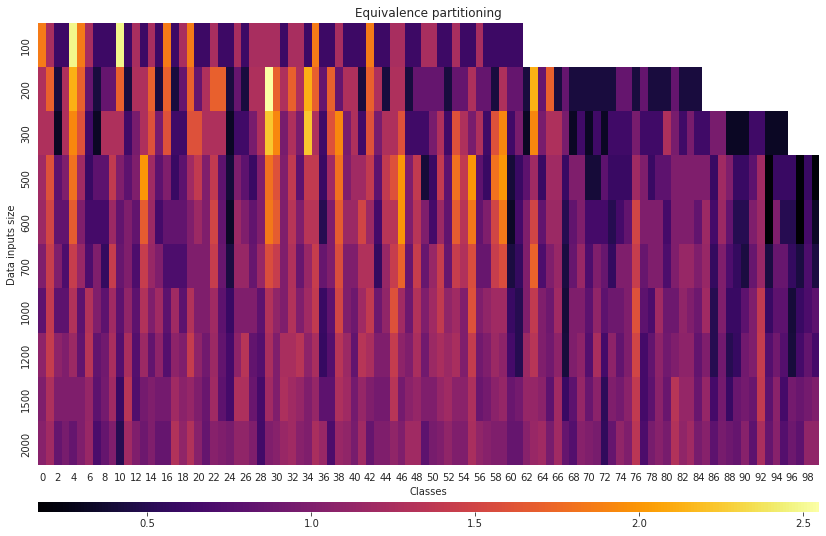

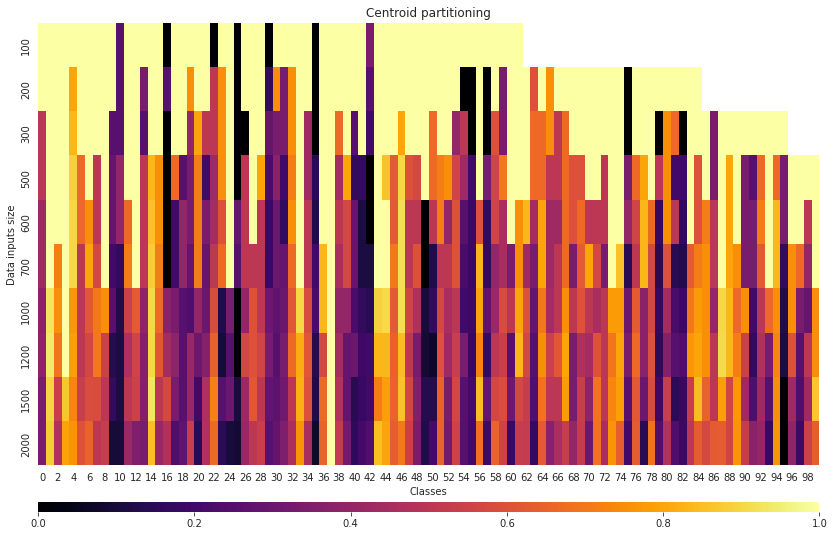

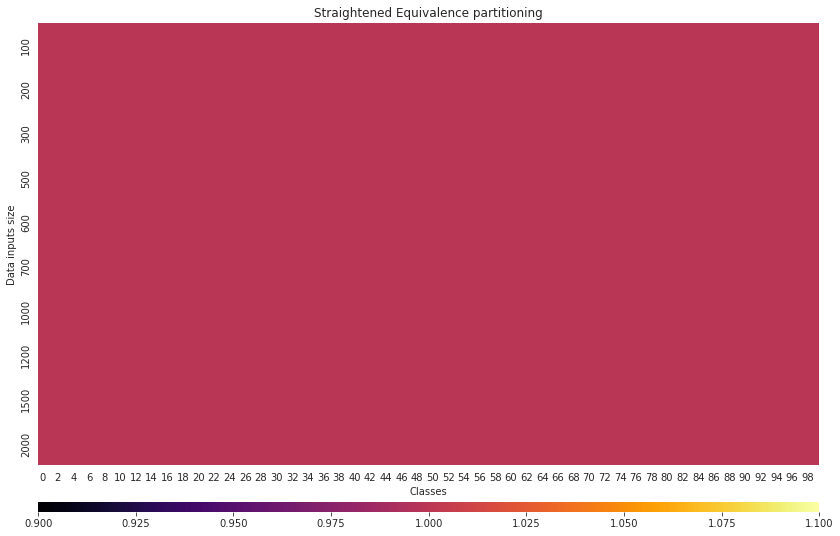

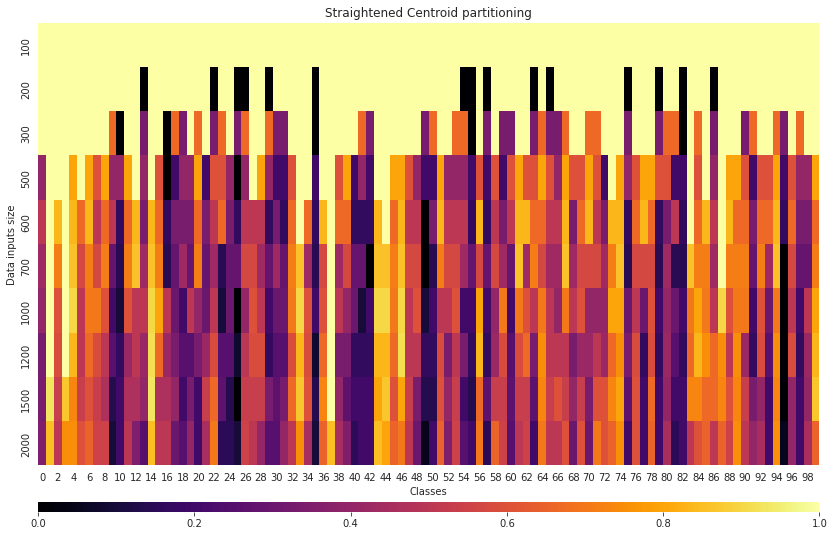

In [108]:
# keys = ['equivalence_part', 'Centroid_part', 'bound_part', 'pairw_part']
import seaborn as sns
keys = ['equivalence_part', 'Centroid_part']
key_labels = {'equivalence_part': "Equivalence partitioning", "Centroid_part": 'Centroid partitioning'}
import matplotlib

import pandas as pd


for net_name, files in all_file_data.items():
    if "inf" in net_name:
        continue
    col = 0
    for key in keys:
        array = []
        xes = []
        yes = []
        for label, data in files[key].items():
            arr = []
            for x,y in data.items():
                arr.append(y)
            xes.append(np.array(arr))
            yes.append(int(label))
            
        grid_kws = {"height_ratios": (.88, .02), "hspace": .16}
        fig, (ax0, cbar_ax) = plt.subplots(2, figsize=(14, 9), gridspec_kw=grid_kws)
        row = 0
        lines = {0: []}
        x, y = zip(*sorted(files[key].items()))
        df = pd.DataFrame(data=xes, index=yes)
        sns.set_style("whitegrid")
        ax0 = sns.heatmap(df, 
                ax=ax0,
                 cbar_ax=cbar_ax,
                 annot=False,
                 square=False,
                  cmap='inferno',
                 cbar_kws={ "orientation": "horizontal"})
        
        ax0.set_title(f"{named_labels[net_name]}{key_labels[key]}")
        ax0.set_xlabel('Classes')
        ax0.set_ylabel('Data inputs size')
        ax0.autoscale(enable=True, axis='y')

        fig.savefig(save_plot_path + f"data_coverage_heat_indiv_{net_name}_{key_labels[key]}.jpg", bbox_inches='tight', transparent=False)
plt.show()

## DSA

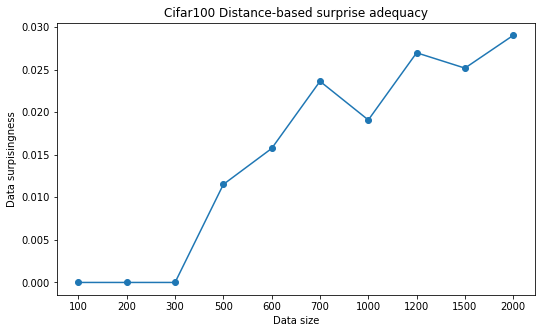

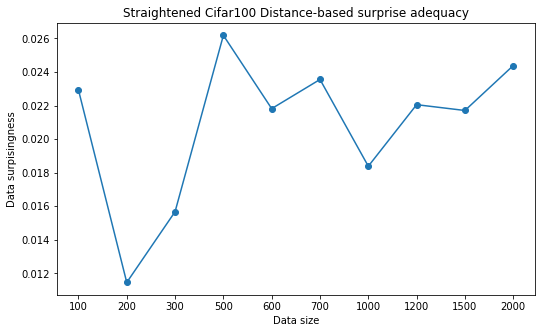

In [5]:
keys = ['lsa_values_']
i = 0
col = 0
for net_name, files in all_file_data.items():
    if "inf" in net_name:
        continue
    lines = {0:[]}
    fig = plt.figure(figsize=(18, 5))
    gs = GridSpec(nrows=1, ncols=2)
    gs.update(wspace=0.1) # set the spacing between axes. 
    lines = {0: []}
    # fig = plt.figure(figsize=(9, 5))
    # gs = GridSpec(nrows=1, ncols=1)
    # gs.update(wspace=0.1) # set the spacing between axes. 
    # fig.suptitle(net_name)
    val = files["lsa_values_"]['mean']
    ax0 = fig.add_subplot(gs[0, col])
    x, y = zip(*natsorted(val.items()))
    # print(x)
    if type(y[0]) == dict:
        continue
    
    # ax0.plot(x, y, marker='o', c='tab:green')
    handles = ax0.plot(x, y, label=f"Input {indexes[label]}", marker='o')
    lines[0].append(handles[0])
    ax0.set_title(f"{named_labels[net_name]}{dataset} Distance-based surprise adequacy")
    
    ax0.set_xlabel('Data size')
    ax0.set_ylabel('Data surpisingness')

    # ax0.legend(handles=lines[0], loc=(0.785, 0.51), title=f"{dataset}")
    # ax0.grid(True)
    # ax0.set_xscale('log')
    # ax0.legend()
    col += 1
    fig.savefig(save_plot_path + f"DSA_plot_{net_name}.jpg", bbox_inches='tight', transparent=False)
    i += 1
plt.show()

## FOL

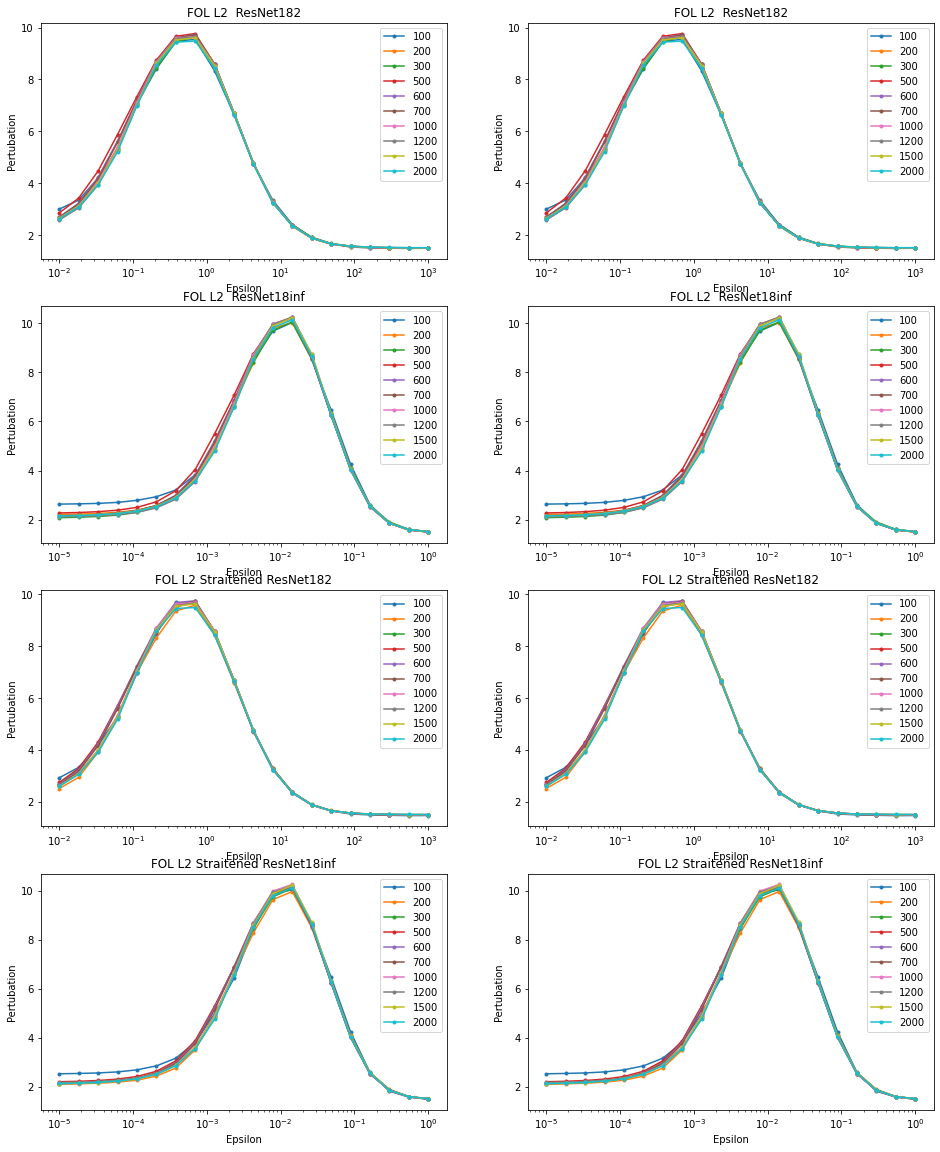

In [84]:
keys = ['fol_L2_']
nrows = 2
ncols = 4
fig = plt.figure(figsize=(nrows * 8, ncols * 5))
gs = GridSpec(ncols=nrows, nrows=ncols)

row = 0
for net_name, files in all_file_data.items():
    col = 0
    for key in keys:
        ax0 = fig.add_subplot(gs[row, 0])
        for k, data in files[key].items():
            ax0.plot(*zip(*natsorted(data.items())), label=f"{k}", marker='.')

        ax0.set_title(f"FOL L2 {net_name}")
        ax0.set_xlabel('Epsilon')
        ax0.set_ylabel('Pertubation')
        ax0.set_xscale('log')
        ax0.legend()

        ax0 = fig.add_subplot(gs[row, 1])
        for k, data in files[key].items():
            ax0.plot(*zip(*natsorted(data.items())), label=f"{k}", marker='.')

        ax0.set_title(f"FOL L2 {net_name}")
        ax0.set_xlabel('Epsilon')
        ax0.set_ylabel('Pertubation')
        ax0.set_xscale('log')
        ax0.legend()
        row += 1

fig.savefig(save_plot_path + "fol_L2.jpg", bbox_inches='tight', transparent=False)
plt.show()

In [88]:
# keys = ['fol_L2_mean']
# nrows = 1
# ncols = 4
# fig = plt.figure(figsize=(nrows * 7, ncols * 5))
# gs = GridSpec(ncols=nrows, nrows=ncols)
# row = 0
# for net_name, files in all_file_data.items():
#     col = 0
#     for key in keys:
#         ax0 = fig.add_subplot(gs[row, 0])
#         # for k, data in files[key].items():
#         ax0.plot(*zip(*natsorted(files[key].items())), label=f"{k}", marker='.')

#         ax0.set_title(f"FOL L2 {net_name}")
#         ax0.set_xlabel('Epsilon')
#         ax0.set_ylabel('Pertubation')
#         # ax0.set_xscale('log')
#         ax0.legend()

#         row += 1

# fig.savefig(save_plot_path + "fol_L2_mean.jpg", bbox_inches='tight', transparent=False)
# plt.show()

In [ ]:
# keys = ['fol_Linf']
# nrows = 2
# ncols = 4
# fig = plt.figure(figsize=(nrows * 8, ncols * 5))
# gs = GridSpec(ncols=nrows, nrows=ncols)

# row = 0
# for net_name, files in clever_scores_means.items():
#     ax0 = fig.add_subplot(gs[row, 0])
#     for k, data in files.items():
#         ax0.plot(*zip(*natsorted(data.items())), label=f"{k}", marker='.')

#     ax0.set_title(f"FOL Linf {net_name}")
#     ax0.set_xlabel('Epsilon')
#     ax0.set_ylabel('Pertubation')
#     ax0.set_xscale('log')
#     ax0.legend()

#     ax0 = fig.add_subplot(gs[row, 1])
#     for k, data in files.items():
#         ax0.plot(*zip(*natsorted(data.items())), label=f"{k}", marker='.')

#     ax0.set_title(f"FOL Linf {net_name}")
#     ax0.set_xlabel('Epsilon')
#     ax0.set_ylabel('Pertubation')
#     ax0.legend()
#     row += 1

# fig.savefig(save_plot_path + "fol_Linf.jpg", bbox_inches='tight', transparent=False)
# plt.show()

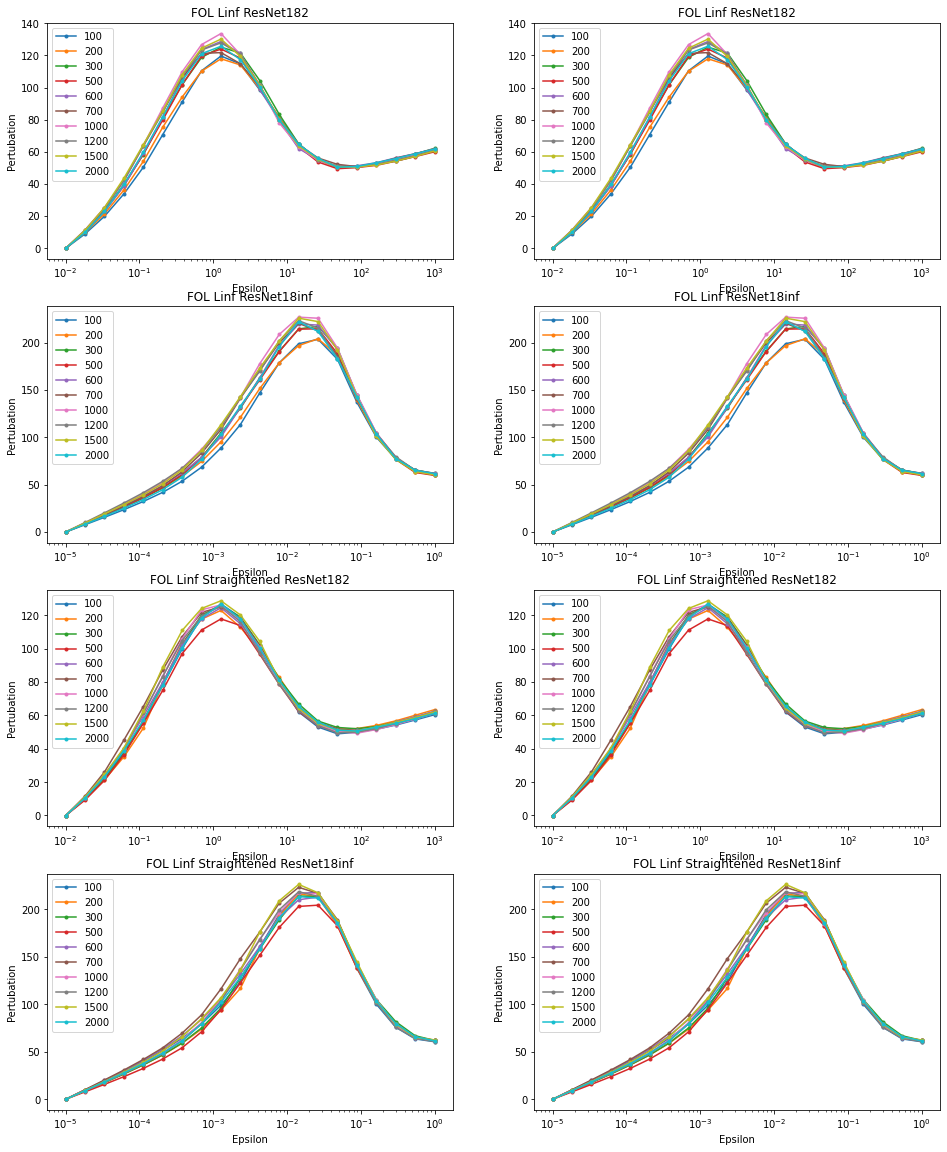

In [6]:
keys = ['fol_Linf_']
nrows = 2
ncols = 4
fig = plt.figure(figsize=(nrows * 8, ncols * 5))
gs = GridSpec(ncols=nrows, nrows=ncols)

row = 0
for net_name, files in all_file_data.items():
    col = 0
    for key in keys:
        ax0 = fig.add_subplot(gs[row, 0])
        for k, data in files[key].items():
            ax0.plot(*zip(*natsorted(data.items())), label=f"{k}", marker='.')

        ax0.set_title(f"FOL Linf {net_name}")
        ax0.set_xlabel('Epsilon')
        ax0.set_ylabel('Pertubation')
        ax0.set_xscale('log')
        ax0.legend()

        ax0 = fig.add_subplot(gs[row, 1])
        for k, data in files[key].items():
            ax0.plot(*zip(*natsorted(data.items())), label=f"{k}", marker='.')

        ax0.set_title(f"FOL Linf {net_name}")
        ax0.set_xlabel('Epsilon')
        ax0.set_ylabel('Pertubation')
        ax0.set_xscale('log')
        ax0.legend()
        row += 1

fig.savefig(save_plot_path + "fol_Linf.jpg", bbox_inches='tight', transparent=False)
plt.show()

In [87]:
# keys = ['fol_Linf_mean']
# nrows = 1
# ncols = 4
# fig = plt.figure(figsize=(nrows * 7, ncols * 5))
# gs = GridSpec(ncols=nrows, nrows=ncols)
# row = 0
# for net_name, files in all_file_data.items():
#     col = 0
#     for key in keys:
#         ax0 = fig.add_subplot(gs[row, 0])
#         # for k, data in files[key].items():
#         ax0.plot(*zip(*natsorted(files[key].items())), label=f"{k}", marker='.')

#         ax0.set_title(f"FOL Linf {net_name}")
#         ax0.set_xlabel('Epsilon')
#         ax0.set_ylabel('Pertubation')
#         # ax0.set_xscale('log')
#         ax0.legend()

#         row += 1

# fig.savefig(save_plot_path + "fol_Linf_mean.jpg", bbox_inches='tight', transparent=False)
# plt.show()

# Robustness

# old

## DNN coverage

## Emperical robustess

## Logits

In [42]:
# keys = ['emperical_robustness_logits_']
# nrows = 3
# ncols = 6

# for net_name, files in all_file_data.items():
#     fig = plt.figure(figsize=(nrows * 7, ncols * 5))
#     gs = GridSpec(ncols=nrows, nrows=ncols)
#     # fig.suptitle(net_name)
#     for key in keys:
#         i = 0
#         col = 0
#         row = 0
#         for type_, val in files[key].items():
#             if i == 2:
#                 break
#             if col % 3 == 0:
#                 row += 1
#                 col = 0

#             ax0 = fig.add_subplot(gs[row, col])
#             for label, data in val.items():
#                 ax0.plot(*zip(*sorted(data.items())), label=f"{label}", marker='.')

#             ax0.set_title(f"{type_}")
#             ax0.set_xlabel('Epsilon')
#             ax0.set_ylabel('Data size')
#             # ax0.set_xscale('log')
#             ax0.legend()

#             col += 1
#             i += 1

#     fig.savefig(save_plot_path + f"emperical_robustness_logits_{net_name}.jpg", bbox_inches='tight', transparent=False)
# plt.show()


In [90]:
# keys = ['emperical_robustness_logits_']
# nrows = 1
# ncols = 2

# for net_name, files in all_file_data.items():
#     # if net_name != "No sampler basic_CNNinf":
#     #     continue 
#     fig = plt.figure(figsize=(28, 24))
#     gs = GridSpec(nrows=3, ncols=2)
#     for key in keys:
#         col = 0
#         row = 0
#         line1 = []
#         line2 = []
#         ax0 = fig.add_subplot(gs[0, col])
#         for type_, val in files[key].items():
#             # print(val)
#             if col % 3 == 0:
#                 row += 1
#                 col = 0
#             for label, data in val.items():
#                 if type_ == 'approx':            
#                     handles1 = ax0.plot(*zip(*sorted(data.items())), label=f"Approximated {indexes[label]}", linestyle='dashed', marker='*')
#                     line1.append(handles1[0])
#                 else:
#                     handles2 = ax0.plot(*zip(*sorted(data.items())), label=f"Robustness {indexes[label]}", marker='o')
#                     line2.append(handles2[0])
#             col += 1
#         ax0.set_title(f"Robustness")
#         ax0.set_xlabel('Epsilon')
#         ax0.set_ylabel('F1')
#         ax0.set_xscale('log')
#         first_legend = ax0.legend(handles=line1, loc=(1.04,0))
#         ax0.add_artist(first_legend)
#         ax0.legend(handles=line2, loc=(1.05, 0.5))
        
#         ax0.autoscale(enable=True, axis='y')
#         col = 0
#         ax0 = fig.add_subplot(gs[1, col])
#         for type_, val in files[key].items():
#             if col % 3 == 0:
#                 row += 1
#                 col = 0
#             for label, data in val.items():
#                 if type_ == 'approx':
#                     ax0.plot(*zip(*sorted(data.items())), label=f"Approximated {indexes[label]}", marker='o')
#             col += 1
#         ax0.set_title(f"Approximated robustness")
#         ax0.set_xlabel('Epsilon')
#         ax0.set_ylabel('F1')
#         ax0.set_xscale('log')
#         ax0.legend(loc=(1.05, 0.5))
#         ax0.autoscale(enable=True, axis='y')

#         col = 0
#         ax0 = fig.add_subplot(gs[2, col])
#         for type_, val in files[key].items():
#             if col % 3 == 0:
#                 row += 1
#                 col = 0
#             for label, data in val.items():
#                 if type_ != 'approx':
#                     ax0.plot(*zip(*sorted(data.items())), label=f"Robustness {indexes[label]}", marker='o')
#             col += 1
#         ax0.set_title(f"Robustness")
#         ax0.set_xlabel('Epsilon')
#         ax0.set_ylabel('F1')
#         ax0.set_xscale('log')
#         ax0.legend(loc=(1.05, 0.5))
#         ax0.autoscale(enable=True, axis='y')
        
#     fig.savefig(save_plot_path + f"emperical_robustness_logits_wide_{net_name}.jpg", bbox_inches='tight', transparent=False)
# plt.show()


## F1

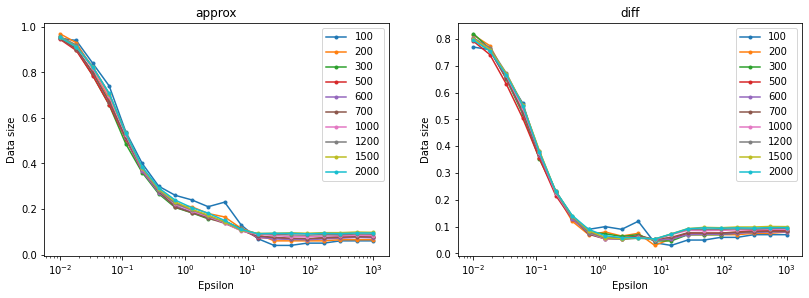

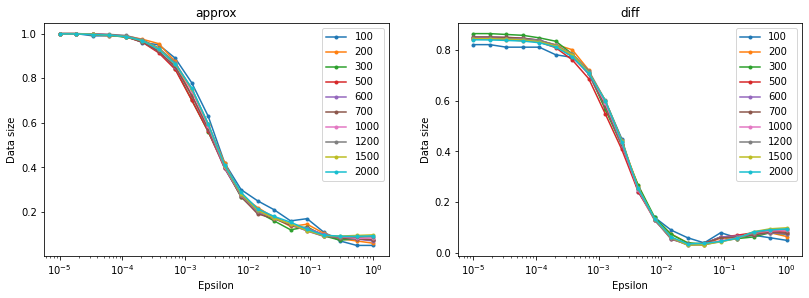

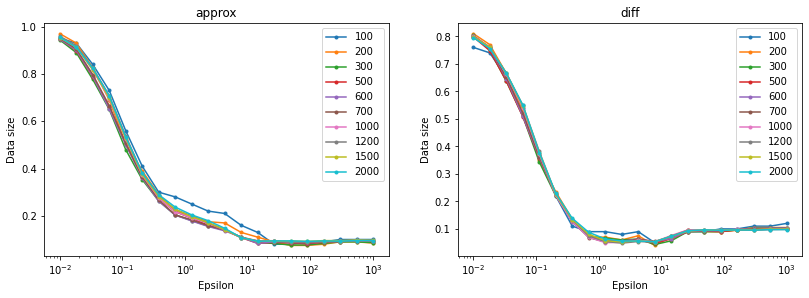

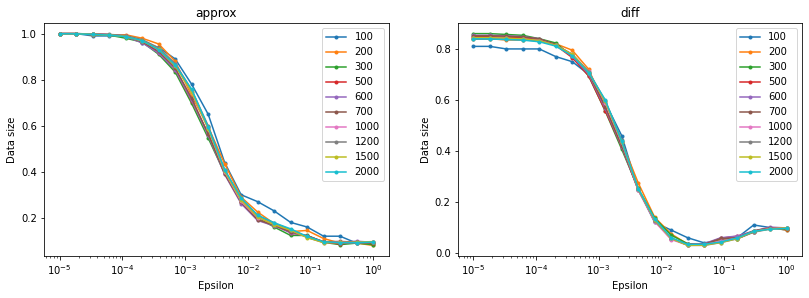

In [89]:
keys = ['emperical_robustness_']
nrows = 3
ncols = 6

for net_name, files in all_file_data.items():
    fig = plt.figure(figsize=(nrows * 7, ncols * 5))
    gs = GridSpec(ncols=nrows, nrows=ncols)
    # fig.suptitle(net_name)
    for key in keys:
        i = 0
        col = 0
        row = 0
        for type_, val in files[key].items():
            if i == 2:
                break
            if col % 3 == 0:
                row += 1
                col = 0

            ax0 = fig.add_subplot(gs[row, col])
            for label, data in val.items():
                ax0.plot(*zip(*sorted(data.items())), label=f"{label}", marker='.')

            ax0.set_title(f"{type_}")
            ax0.set_xlabel('Epsilon')
            ax0.set_ylabel('Data size')
            ax0.set_xscale('log')
            ax0.legend()

            col += 1
            i += 1

    fig.savefig(save_plot_path + f"emperical_robustness_f1_{net_name}.jpg", bbox_inches='tight', transparent=False)
plt.show()


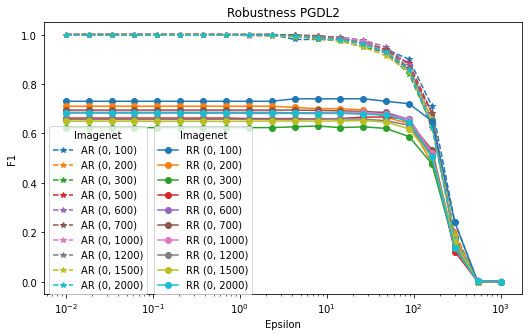

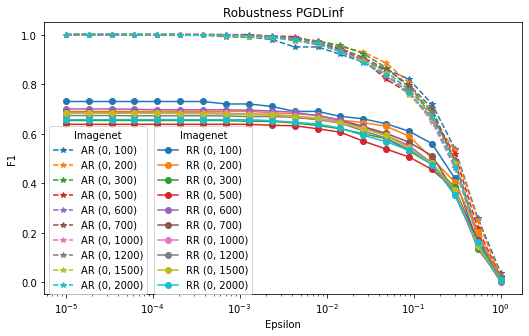

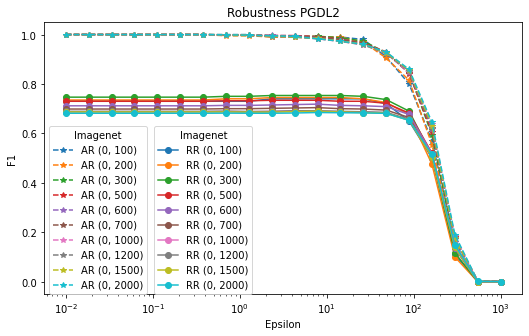

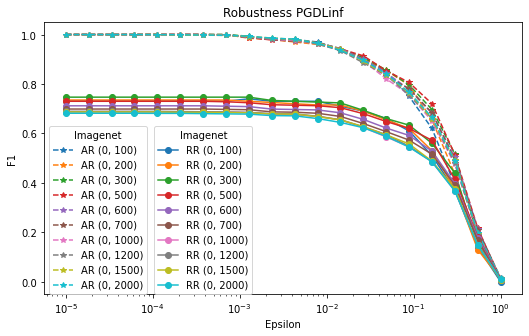

In [50]:
keys = ['emperical_robustness_']
nrows = 1
ncols = 2
y_name = "F1"
x_name = 'Epsilon'
for net_name, files in all_file_data.items():
    # print(net_name)
    # if net_name != "No sampler basic_CNNinf":
    #     continue 
    fig = plt.figure(figsize=(18, 5))
    gs = GridSpec(nrows=1, ncols=2)
    gs.update(wspace=0.1) # set the spacing between axes. 
    for key in keys:
        col = 0
        row = 0
        lines = {0: [], 1: [], 2: []}
        ax0 = fig.add_subplot(gs[0, col])
        for type_, val in files[key].items():
            # print(val)
            if col % 3 == 0:
                row += 1
                col = 0
            for label, data in val.items():
                if type_ == 'approx':
                    handles1 = ax0.plot(*zip(*sorted(data.items())), label=f"AR {indexes[label]}", linestyle='dashed', marker='*')
                    lines[0].append(handles1[0])
                else:
                    handles2 = ax0.plot(*zip(*sorted(data.items())), label=f"RR {indexes[label]}", marker='o')
                    lines[1].append(handles2[0])
            col += 1
        ax0.set_title(f"Robustness " + attack_list[net_name])
        ax0.set_xlabel(x_name)
        ax0.set_ylabel(y_name)
        ax0.set_xscale('log')
        if dataset == "imagenet" or dataset == "Imagenet":
            ax0.add_artist(ax0.legend(handles=lines[1], loc=(0.23, 0.), title=dataset))
            ax0.legend(handles=lines[0], loc=(0.01,0.), title=dataset)
        else:
            ax0.add_artist(ax0.legend(handles=lines[1], loc=(0.793, 0.35), title=dataset))
            # first_legend = ax0.legend(handles=lines[0], loc=(1.04,0))
            # ax0.add_artist(first_legend)
            ax0.legend(handles=lines[0], loc=(0.575, 0.35), title=dataset)
        
        ax0.autoscale(enable=True, axis='y')

    fig.savefig(save_plot_path + f"approx_small_offset_calc_{net_name}.jpg", bbox_inches='tight', transparent=False)
plt.show()


In [ ]:
import copy
from sklearn import metrics
from scipy import stats

keys = ['emperical_robustness_']
nrows = 1
ncols = 2
y_name = "F1"
x_name = 'Epsilon'
for net_name, files in all_file_data.items():
    correlation, pvalue = {}, {}
    print_ = False

    # def confidence_score(r, size, alpha=0.05):
    #     r_z = np.arctanh(r)
    #     se = 1/np.sqrt(size-3)
    #     z = stats.norm.ppf(1-alpha/2)
    #     lo_z, hi_z = r_z-z*se, r_z+z*se
    #     lo, hi = np.tanh((lo_z, hi_z))

    #     return lo, hi

    # from scipy.stats import spearmanr

    correlation_labels, correlation_title = {}, {}

    correlation_labels['approx_correlation_diff'] = "Pearson correlation"
    correlation_labels['tau_approx_correlation_diff'] = "Kendall's tau correlation"
    correlation_labels['spear_approx_correlation_diff'] = "correlation"

    correlation_labels['approx_diff_pvalue'] = "Pearson correlation"
    correlation_labels['tau_approx_diff_pvalue'] = "Kendall's tau correlation"
    correlation_labels['spear_approx_diff_pvalue'] = "P-values"

    correlation_title[0] = "Calculated vs approx pearson"
    correlation_title[1] = "Calculated vs approx Kendall"
    correlation_title[3] = "Calculated vs approx Spearman"
    # print(net_name)
    # if net_name != "No sampler basic_CNNinf":
    #     continue 
    # fig = plt.figure(figsize=(18, 5))
    # gs = GridSpec(nrows=1, ncols=2)
    # gs.update(wspace=0.1) # set the spacing between axes. 
        # col = 0
        # row = 0
        # lines = {0: [], 1: [], 2: []}
        # ax0 = fig.add_subplot(gs[0, col])
        # for type_, val in files[key].items():
        #     # print(val)
        #     if col % 3 == 0:
        #         row += 1
        #         col = 0
        #     for label, data in val.items():
        #         if type_ == 'approx':

    # correlation_example, pvalue_example = {0:{}}, {0:{}}
    for key in keys:
        correlation[_id] = {}
        pvalue[_id] = {}
        for type_, val in files[key].items():
            correlation[_id][attack_key] = {}
            pvalue[_id][attack_key] = {}

            approx_by_eps = {}
            calc_by_eps = {}
            correlation[_id][attack_key]['approx_correlation_diff'] = {}
            correlation[_id][attack_key]['tau_approx_correlation_diff'] = {}
            correlation[_id][attack_key]['spear_approx_correlation_diff'] = {}

            pvalue[_id][attack_key]['approx_diff_pvalue'] = {}
            pvalue[_id][attack_key]['tau_approx_diff_pvalue'] = {}
            pvalue[_id][attack_key]['spear_approx_diff_pvalue'] = {}
            for type_, val in files[key].items():
            # for data_size in natsorted(approx_robustness_means[proj_id1][_id][attack_key].keys()):
                for label, data in val.items():
                # for eps in approx_robustness_means[proj_id1][_id][attack_key][data_size].keys():
                    if label not in approx_by_eps:
                        approx_by_eps[label] = []
                        calc_by_eps[label] = []

                    approx_by_eps[label].append(approx_robustness_means[proj_id1][_id][attack_key][data_size][eps])   
                    calc_by_eps[label].append(calc_diff_robustness_means[proj_id1][_id][attack_key][data_size][eps])   

            for eps in approx_by_eps.keys():
                approx_ = approx_by_eps[eps]
                calc_diff_ = calc_by_eps[eps]
                if len(approx_) < 2 or len(calc_diff_) < 2:
                    continue

                # approximated augmented vs calculated(/)
                approx_correlation_diff, approx_diff_pvalue = stats.pearsonr(approx_, calc_diff_)
                
                tau_approx_correlation_diff, tau_approx_diff_pvalue = stats.kendalltau(approx_, calc_diff_)

                spear_approx_correlation_diff, spear_approx_diff_pvalue = stats.spearmanr(approx_, calc_diff_)
                
                if np.isnan(approx_correlation_diff):
                    print("approx", approx_, "calc", calc_diff_)
                    approx_correlation, approx_pvalue, approx_correlation_diff, approx_diff_pvalue = 0., 0., 0., 0.
                    tau_approx_correlation_diff, tau_pvalue = 0., 0.

                correlation[_id][attack_key]['approx_correlation_diff'][eps] = approx_correlation_diff
                correlation[_id][attack_key]['tau_approx_correlation_diff'][eps] = tau_approx_correlation_diff
                correlation[_id][attack_key]['spear_approx_correlation_diff'][eps] = spear_approx_correlation_diff

                pvalue[_id][attack_key]['approx_diff_pvalue'][eps] = approx_diff_pvalue
                pvalue[_id][attack_key]['tau_approx_diff_pvalue'][eps] = tau_approx_diff_pvalue
                pvalue[_id][attack_key]['spear_approx_diff_pvalue'][eps] = spear_approx_diff_pvalue

    for id_ in correlation.keys():
        if _id == 126:
            x_name = 'Sigma'
        else:
            x_name = 'Epsilon'
        ncols = 1
        fig = plt.figure(figsize=(9, 5))
        gs = GridSpec(nrows=2, ncols=ncols, wspace=0.0, hspace=0.0, height_ratios=[2,1.25])
        # for attack_key in correlation[id_].keys():
            # print(correlation[id_][attack_key])
        
        for attack_key in correlation[id_].keys():
            ax0 = fig.add_subplot(gs[0, 0])
            title = ""
            correlation_metric = correlation[id_][attack_key]
            # print(correlation_metric)
            method = "spear_approx_correlation_diff"
            # for label, corr in correlation_metric.items():
            handles0 = ax0.plot(*zip(*sorted(correlation_metric[method].items())), c='tab:green', label=correlation_labels[method], marker='o')

            attack_title = attack_key
            if attack_key == "Uniform":
                attack_title = "Uniform noise"
            
            ax0.set_title(f"{name[proj_id1]} Spearman correlation " + str(attack_title))
            ax0.set_xlabel("")
            # ax0.axes.xaxis.set_visible(False)
            ax0.axes.xaxis.set_ticklabels([])
            ax0.grid(True)
            ax0.set_ylabel('Robustness correlation')
            ax0.set_xscale('log')
            # ax0.legend(title=name[proj_id1])

            pvalues = pvalue[id_][attack_key]
            method = "spear_approx_diff_pvalue"
            ax1 = fig.add_subplot(gs[1, 0])
            title = ""

            # for label, p in pvalues.items():
            handles1 = ax1.plot(*zip(*sorted(pvalues[method].items())), c='tab:blue', label=correlation_labels[method], marker='o')

            handles2 = ax1.axhline(y=0.05, color='r', label="Significance(.05)", linestyle='-')
            line = [handles0[0], handles1[0], handles2]
            
            ax1.set_title("")
            ax1.set_xlabel(x_name)
            ax1.set_ylabel('P-values')
            ax1.set_xscale('log')
            first_legend = ax1.legend(handles=line, loc=(0.13,-0.5), title=name[proj_id1], ncol=3)
            ax1.add_artist(first_legend)
            ax1.grid(True)
            # ax1.legend(title=name[proj_id1], ncols=3)

            plt.savefig(f"data/result_plots/robustness_small_correlation_{proj_id1}_{attack_key}({str(id_)}).jpg", bbox_inches='tight')

    plt.show()

        #             handles2 = ax0.plot(*zip(*sorted(_calc_diff.items())), label=f"Calculated {data_size}", marker='o')
                
        #         line2.append(handles2[0])

        # first_legend = ax0.legend(handles=line1, loc=(1.04,0), title=name[proj_id1])
        # ax0.add_artist(first_legend)

## other


In [22]:
# keys = ['emperical_robustness_logits_mean']
# nrows = 3
# ncols = 6
# for net_name, files in all_file_data.items():
#     fig = plt.figure(figsize=(nrows * 8, ncols * 5))
#     # fig.suptitle(net_name)
#     gs = GridSpec(ncols=nrows, nrows=ncols)
#     row = 0
#     for key in keys:
#         col = 0
#         # ax0 = fig.add_subplot(gs[row, col])
#         for k, data in files[key].items():
#             if col % 3 == 0:
#                 row += 1
#                 col = 0

#             ax0 = fig.add_subplot(gs[row, col])
#             ax0.plot(*zip(*natsorted(data.items())), label=f"{k}", marker='.')

#             ax0.set_title(f"Emp. rob {k}")
#             ax0.set_xlabel('Epsilon')
#             ax0.set_ylabel('Data size')
#             # ax0.set_xscale('log')
#             ax0.legend()

#             col += 1

# fig.savefig(save_plot_path + "emperical_robustness_logit_mean.jpg", bbox_inches='tight', transparent=False)
# plt.show()

In [23]:
# keys = ['emperical_robustness_mean']
# nrows = 3
# ncols = 6
# for net_name, files in all_file_data.items():
#     fig = plt.figure(figsize=(nrows * 8, ncols * 5))
#     # fig.suptitle(net_name)
#     gs = GridSpec(ncols=nrows, nrows=ncols)
#     row = 0
#     for key in keys:
#         col = 0
#         # ax0 = fig.add_subplot(gs[row, col])
#         for k, data in files[key].items():
#             if col % 3 == 0:
#                 row += 1
#                 col = 0

#             ax0 = fig.add_subplot(gs[row, col])
#             ax0.plot(*zip(*natsorted(data.items())), label=f"{k}", marker='.')

#             ax0.set_title(f"Emp. rob {k}")
#             ax0.set_xlabel('Epsilon')
#             ax0.set_ylabel('Data size')
#             # ax0.set_xscale('log')
#             ax0.legend()

#             col += 1

# fig.savefig(save_plot_path + "emperical_robustness_f1_mean.jpg", bbox_inches='tight', transparent=False)
# plt.show()

# AMISE

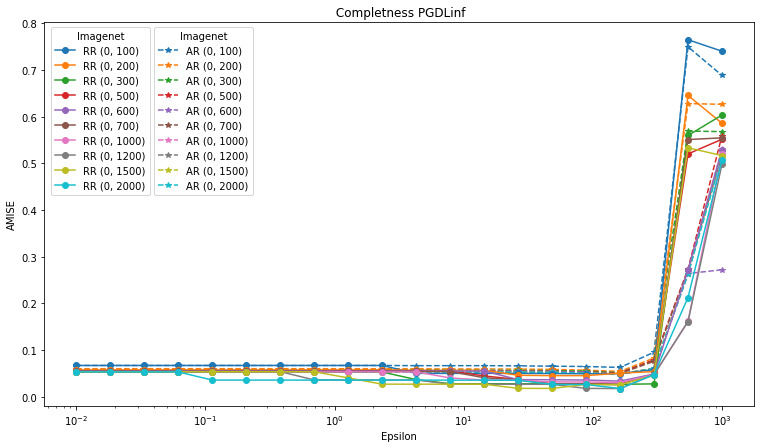

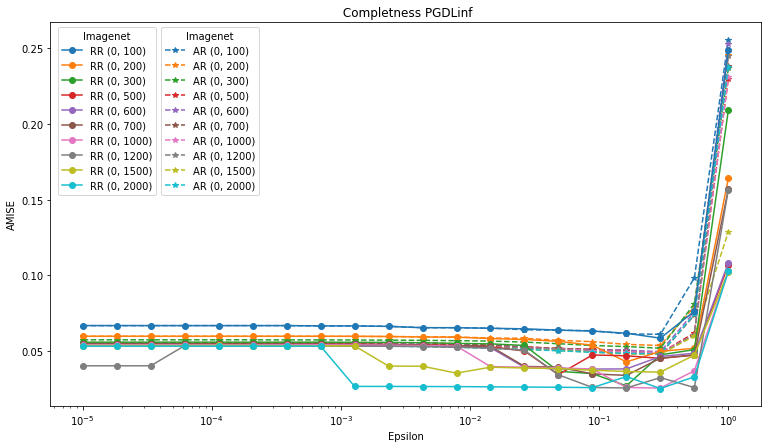

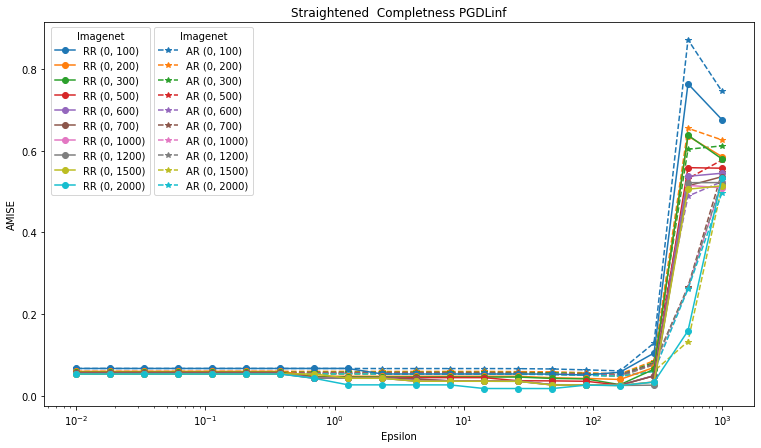

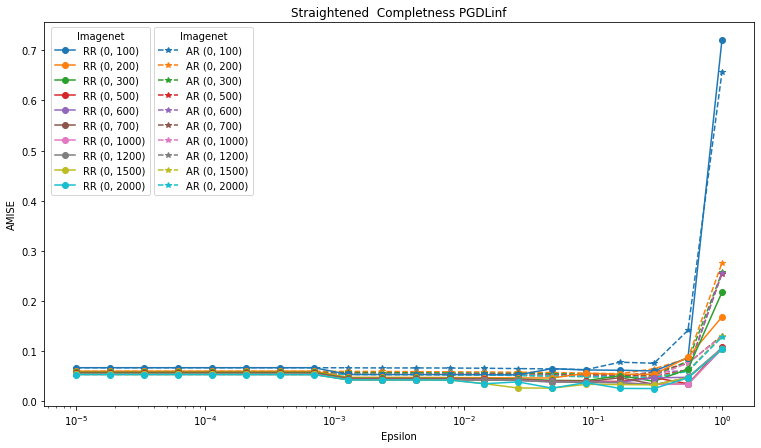

In [4]:
keys = ['amise_f1_']
nrows = 1
ncols = 2

x_name = 'Epsilon'
y_name = 'AMISE'
_LL = copy.deepcopy(all_file_data)
for net_name, files in _LL.items():
    fig = plt.figure(figsize=(28, 24))
    gs = GridSpec(nrows=3, ncols=2)
    for key in keys:
        col = 0
        row = 0
        ax0 = fig.add_subplot(gs[0, col])
        lines  = {0:[], 1:[]}
        for type_, val in files[key].items():
            if col % 3 == 0:
                row += 1
                col = 0
            for label, data in val.items():                        
                x, y = zip(*sorted(data.items()))
                if type_ != 'approx':
                    handles2 = ax0.plot(x, y, label=f"RR {indexes[label]}", marker='o')
                    lines[0].append(handles2[0])
                else:
                    handles1 = ax0.plot(x, y, label=f"AR {indexes[label]}", linestyle='dashed', marker='*')
                    lines[1].append(handles1[0])
            col += 1
        ax0.set_title(f"{named_labels[net_name]} Completness {attack}")
        ax0.set_xlabel(x_name)
        ax0.set_ylabel(y_name)
        ax0.set_xscale('log')
        ax0.grid(False)
        ax0.add_artist(ax0.legend(handles=lines[0], loc=(0.01, 0.55), title=dataset))
        ax0.legend(handles=lines[1], loc=(0.155, 0.55), title=dataset)

        ax0.autoscale(enable=True, axis='y')
plt.show()

../project_data/experiment1/result_plots/run1/
../project_data/experiment1/result_plots/run1/
../project_data/experiment1/result_plots/run1/
../project_data/experiment1/result_plots/run1/


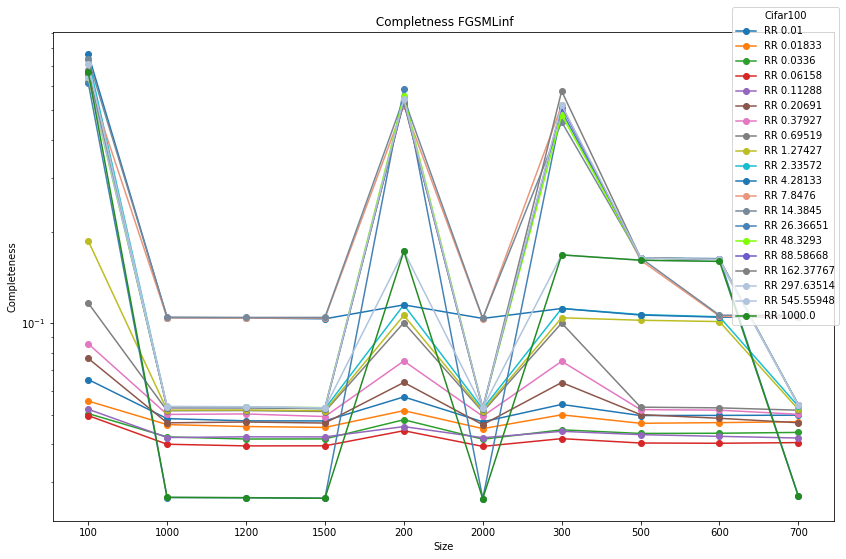

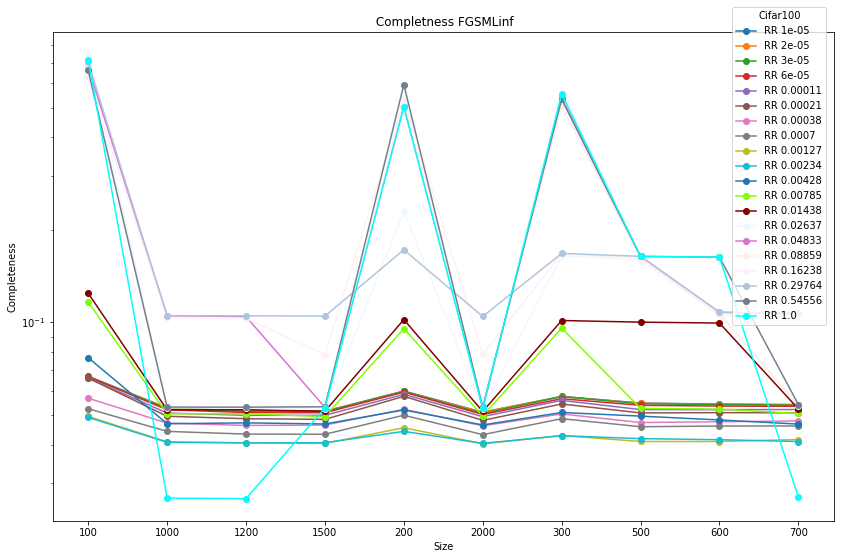

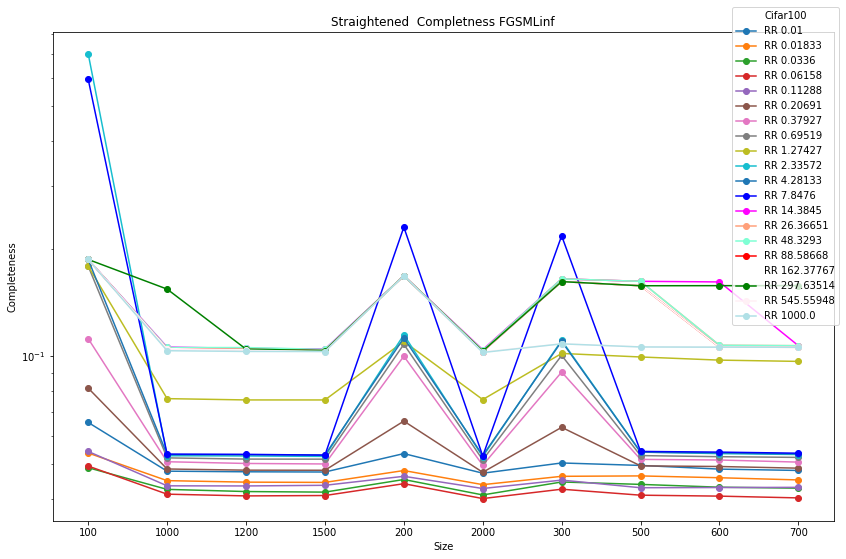

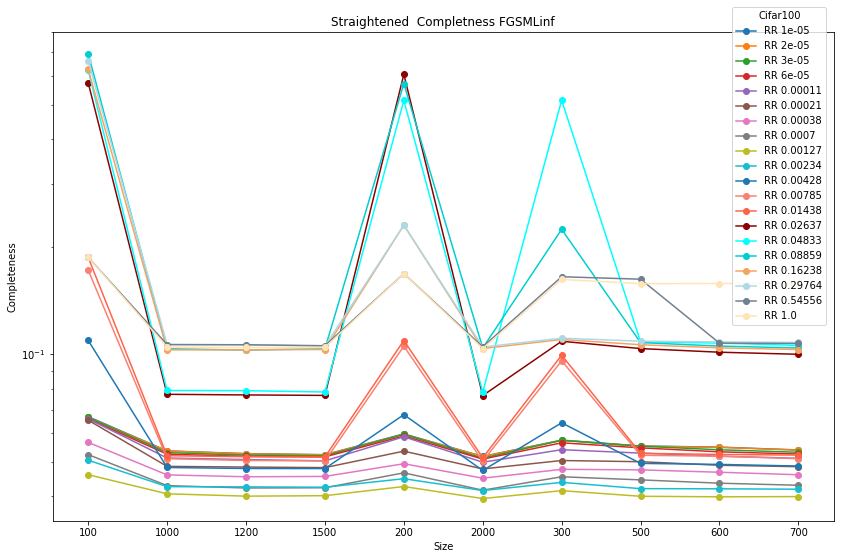

In [43]:

import matplotlib.colors as pltc
all_colors = [k for k,v in pltc.cnames.items()]
import random
keys = ['amise_f1__']
nrows = 1
ncols = 2
NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')

_all = copy.deepcopy(all_file_data)
for net_name, files in _all.items():
    # if net_name != "No sampler basic_CNNinf":
    #     continue 
    fig = plt.figure(figsize=(14, 9))
    gs = GridSpec(nrows=1, ncols=1)
    for key in keys:
        col = 0
        row = 0
        line1 = []
        line2 = []
        ax0 = fig.add_subplot(gs[0, 0])
        for type_ in reversed(files[key]):
            val = files[key][type_]
            # print(val)
            if col % 3 == 0:
                row += 1
                col = 0
            i_plots = 0
            for label, data in val.items():
                if type_ != 'approx':
                    for _k, val in natsorted(data.items()):
                        if val > 1:
                            data[_k] = val / 1100000
                    #         data[_k] = 1
                            
                    x, y = zip(*sorted(natsorted(data.items())))
                    if i_plots > 10:
                        handles2 = ax0.plot(x,y, label=f"RR {round(label, 5)}", c=random.choice(all_colors), marker='o')
                    else:
                        handles2 = ax0.plot(x,y, label=f"RR {round(label, 5)}", marker='o')

                    line1.append(handles2[0])
                # else:    
                #     handles1 = ax0.plot(*zip(*natsorted(data.items())), label=f" ", linestyle='dashed', marker='*')
                #     line1.append(handles1[0])
                i_plots += 1
            col += 1

        ax0.set_title(f"{named_labels[net_name]} Completness {attack}")
        # ax0.set_title(f"{named_labels[net_name]}{dataset} Distance-based surprise adequacy")
        ax0.set_xlabel('Size')
        ax0.set_ylabel('Completeness')
        ax0.set_yscale('log')
        
        # ax0.add_artist(ax0.legend(handles=line1, loc=(0.793, 0.38), title=dataset))
        
        # first_legend = ax0.legend(handles=lines[0], loc=(1.04,0))
        # ax0.add_artist(first_legend)
        ax0.legend(handles=line1, loc=(0.87, 0.4), title=dataset)#, ncol=2)
        
        ax0.autoscale(enable=True, axis='y')
    print(save_plot_path)
plt.show()

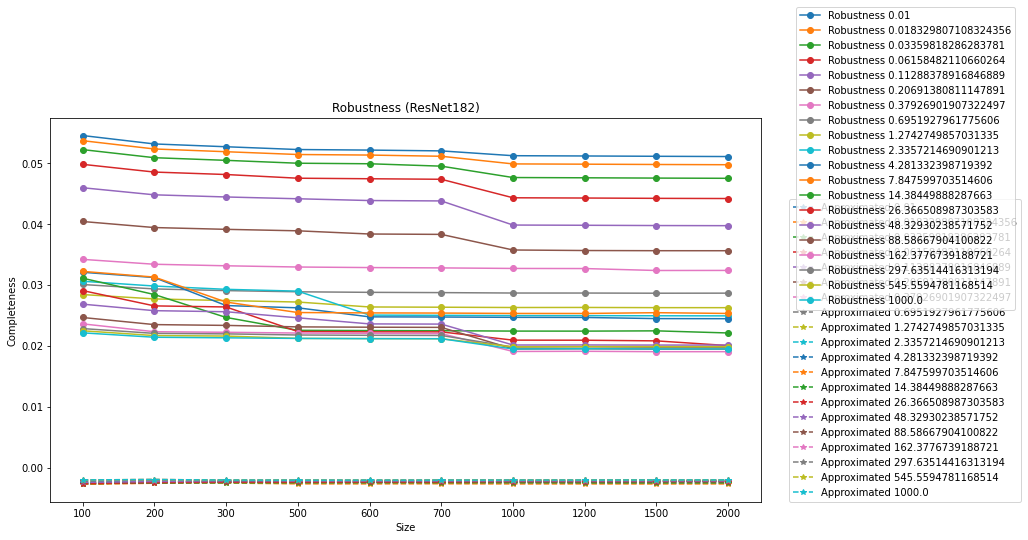

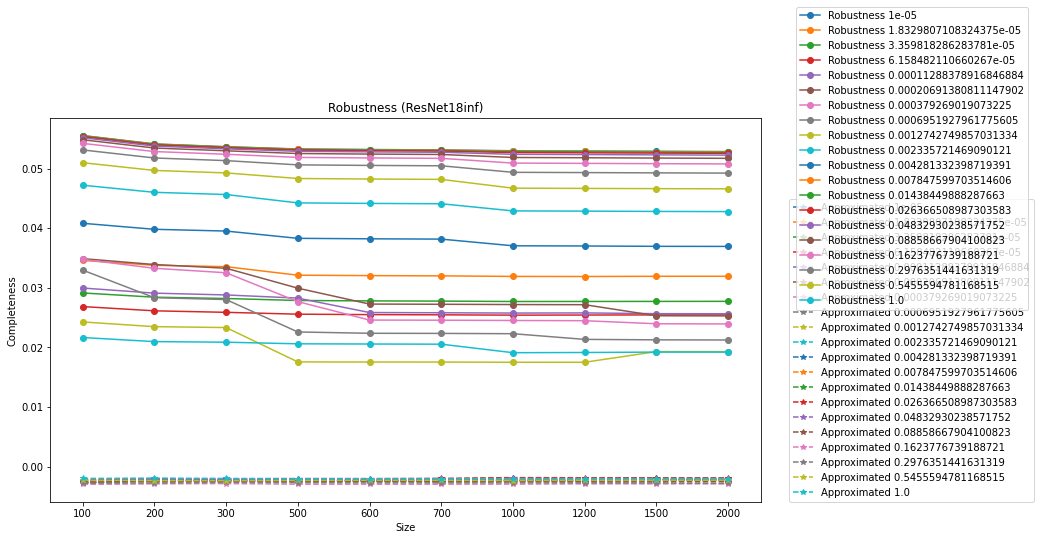

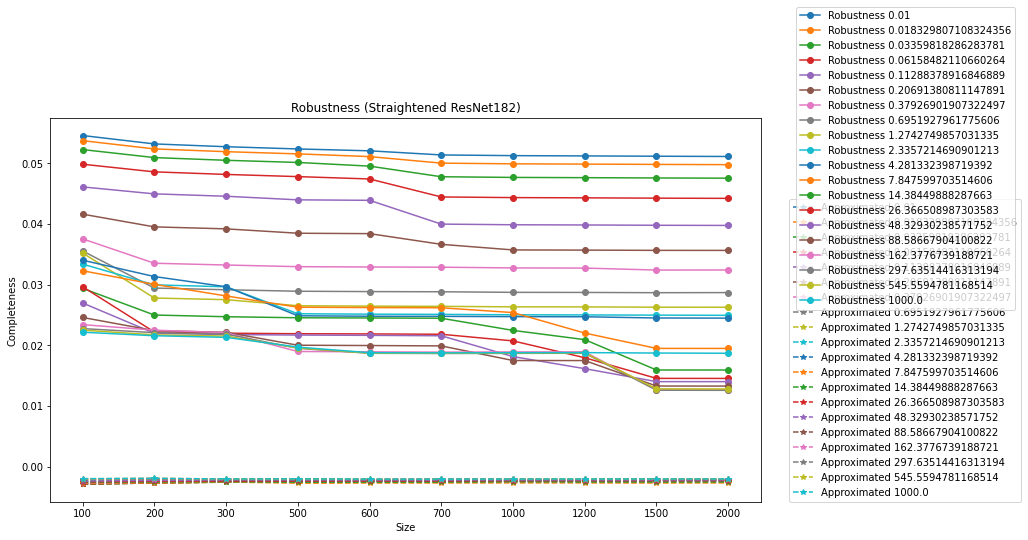

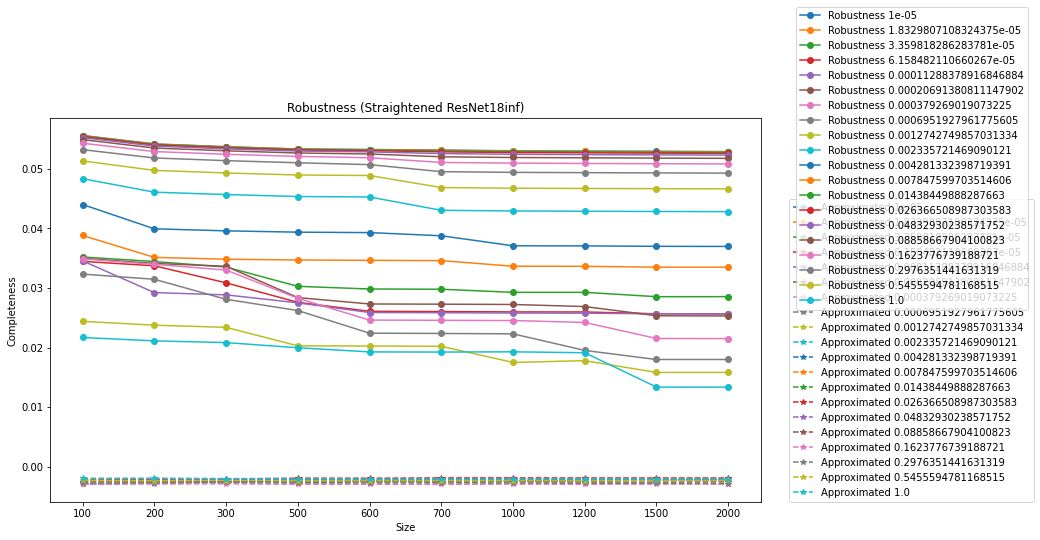

In [67]:
# LOGITS
keys = ['amise__']
nrows = 1
ncols = 2

for net_name, files in all_file_data.items():
    # if net_name != "No sampler basic_CNNinf":
    #     continue 
    fig = plt.figure(figsize=(28, 24))
    gs = GridSpec(nrows=3, ncols=2)
    for key in keys:
        col = 0
        row = 0
        line1 = []
        line2 = []
        ax0 = fig.add_subplot(gs[0, col])
        for type_, val in files[key].items():
            # print(val)
            if col % 3 == 0:
                row += 1
                col = 0
            for label, data in val.items():
                if type_ == 'approx':            
                    handles1 = ax0.plot(*zip(*natsorted(data.items())), label=f"Approximated {label}", linestyle='dashed', marker='*')
                    line1.append(handles1[0])
                else:
                    handles2 = ax0.plot(*zip(*natsorted(data.items())), label=f"Robustness {label}", marker='o')
                    line2.append(handles2[0])
            col += 1
        ax0.set_title(f"Robustness ({net_name})")
        ax0.set_xlabel('Size')
        ax0.set_ylabel('Completeness')
        # ax0.set_xscale('log')
        first_legend = ax0.legend(handles=line1, loc=(1.04,0))
        ax0.add_artist(first_legend)
        ax0.legend(handles=line2, loc=(1.05, 0.5))
        
        ax0.autoscale(enable=True, axis='y')
plt.show()

# CLEVER

In [35]:
nrows = 2
ncols = 4
fig = plt.figure(figsize=(nrows * 7, ncols * 5))
gs = GridSpec(ncols=nrows, nrows=ncols)

row = 0
for net_name, files in clever_scores_means.items():
    ax0 = fig.add_subplot(gs[row, 0])
    for k, data in files.items():
        ax0.plot(*zip(*sorted(data.items())), label=f"{k}", marker='.')

    ax0.set_title(f"CLEVER scores {net_name}")
    ax0.set_xlabel('Epsilon')
    ax0.set_ylabel('Lower bound')
    ax0.set_xscale('log')
    ax0.legend()

    ax0 = fig.add_subplot(gs[row, 1])
    for k, data in files.items():
        ax0.plot(*zip(*sorted(data.items())), label=f"{k}", marker='.')

    ax0.set_title(f"CLEVER scores {net_name}")
    ax0.set_xlabel('Epsilon')
    ax0.set_ylabel('Lower bound')
    ax0.legend()
    row += 1

    fig.savefig(save_plot_path + "CLEVER_L.jpg", bbox_inches='tight', transparent=False)
plt.show()

NameError: name 'clever_scores_means' is not defined

<Figure size 1008x1440 with 0 Axes>

KeyError: 'clever_mean'

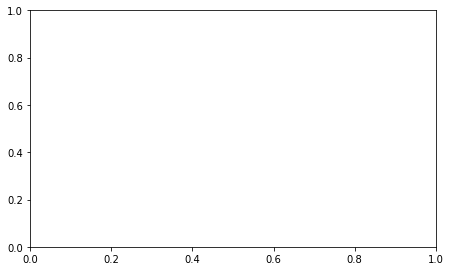

In [ ]:
keys = ['clever_mean']
nrows = 2
ncols = 4
fig = plt.figure(figsize=(nrows * 8, ncols * 5))
gs = GridSpec(ncols=nrows, nrows=ncols)
row = 0
for net_name, files in all_file_data.items():
    col = 0
    for key in keys:
        ax0 = fig.add_subplot(gs[row, 0])
        # for label, data in files[key].items():
        ax0.plot(*zip(*sorted(files[key].items())), marker='.')
        ax0.set_title(f"{key} {net_name}")
        ax0.set_xlabel('Epsilon')
        ax0.set_ylabel('Robustness')
        ax0.set_xscale('log')
        # ax0.legend()
        
        ax0 = fig.add_subplot(gs[row, 1])
        # for k, data in files[key].items():
        ax0.plot(*zip(*natsorted(files[key].items())), marker='.')

        ax0.set_title(f"{key} {net_name}")
        ax0.set_xlabel('Epsilon')
        ax0.set_ylabel('Robustness')
        # ax0.legend()
        row += 1

fig.savefig(save_plot_path + "data_coverage_plot.jpg", bbox_inches='tight', transparent=False)
plt.show()

# Completeness

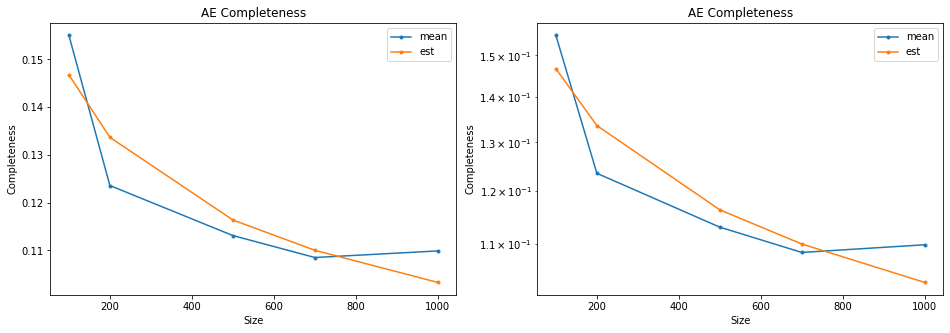

In [76]:
keys = ['completeness_']
from scipy.optimize import curve_fit
nrows = 1
ncols = 2

def funct(x, p1, p2):
    return p1 * np.log(x) + p2

for net_name, files in all_file_data.items():
    fig = plt.figure(figsize=(ncols * 8, nrows * 5))
    gs = GridSpec(ncols=ncols, nrows=nrows)
    for key in keys:
        i = 0
        col = 0
        row = 0
        data = files[key]
        for type_, val in data['all'].items():
            val = sum(val.values()) / len(val)

        x, y = zip(*natsorted(data['mean'].items()))
        x = np.array(x, dtype=float)
        y = np.array(y, dtype=float)

        popt, pcov = curve_fit(funct, x, y, p0=(y.min(), y.max()))
        y_fit = funct(x, popt[0], popt[1])

        ax0 = fig.add_subplot(gs[row, col])
        ax0.plot(x, y, label="mean", marker='.')
        ax0.plot(x, y_fit, label="est", marker='.')

        ax0.set_title(f"AE Completeness")
        ax0.set_xlabel('Size')
        ax0.set_ylabel('Completeness')

        ax0.legend()

        ax0 = fig.add_subplot(gs[row, col+1])
        ax0.plot(x, y, label="mean", marker='.')
        ax0.plot(x, y_fit, label="est", marker='.')
        # ax0.plot(*zip(*natsorted(data['all'].items())), label="all", marker='.')

        ax0.set_title(f"AE Completeness")
        ax0.set_xlabel('Size')
        ax0.set_ylabel('Completeness')

        ax0.set_yscale('log')
        ax0.legend()
        
    fig.savefig(save_plot_path + f"completeness_{net_name}.jpg", bbox_inches='tight', transparent=False)
    break
plt.show()

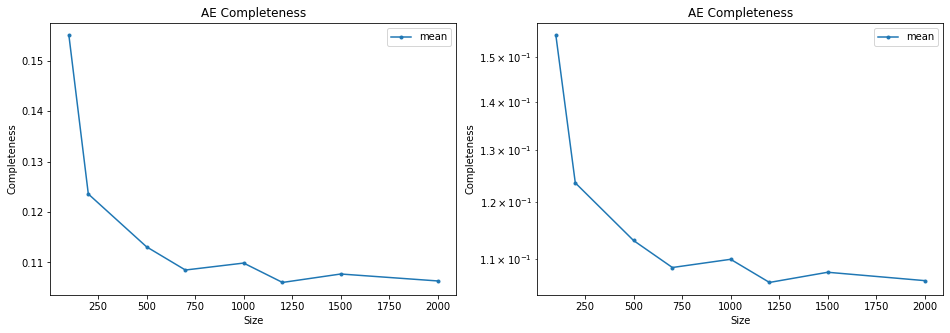

In [30]:
keys = ['completeness_']
nrows = 1
ncols = 2

for net_name, files in all_file_data.items():
    fig = plt.figure(figsize=(ncols * 8, nrows * 5))
    gs = GridSpec(ncols=ncols, nrows=nrows)
    # fig.suptitle(net_name)
    for key in keys:
        i = 0
        col = 0
        row = 0
        # print(files[key])
        data = files[key]
        for type_, val in data['all'].items():
            val = sum(val.values()) / len(val)

        x, y = zip(*natsorted(data['mean'].items()))
        x = np.array(x, dtype=float)
        y = np.array(y, dtype=float)

        ax0 = fig.add_subplot(gs[row, col])
        ax0.plot(x, y, label="mean", marker='.')
        # ax0.plot(*zip(*natsorted(data['all'].items())), label="all", marker='.')

        ax0.set_title(f"AE Completeness")
        ax0.set_xlabel('Size')
        ax0.set_ylabel('Completeness')

        # ax0.set_xscale('log')
        ax0.legend()

        ax0 = fig.add_subplot(gs[row, col+1])
        ax0.plot(x, y, label="mean", marker='.')
        # ax0.plot(*zip(*natsorted(data['all'].items())), label="all", marker='.')

        ax0.set_title(f"AE Completeness")
        ax0.set_xlabel('Size')
        ax0.set_ylabel('Completeness')

        ax0.set_yscale('log')
        ax0.legend()

    fig.savefig(save_plot_path + f"completness_.jpg", bbox_inches='tight', transparent=False)
    break
plt.show()